# Palmer Penguins Dataset
By Colin MacRae

I propose a multiclass classification task on the penguin dataset to determine the species of a penguin (there are three species in the dataset) and, time permitting, a binary classification task to determine the sex of a penguin. I would like to approach this task with a multilayer perceptron and a kernel SVM. I think these are appropriate models given the large number of numerical features. I also think it would be worthwhile to try recursive feature elimination and even SMOTE to attempt to improve model performance.

www.comacrae.com

## Introduction


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras
from keras import layers
from google.colab import drive
from tqdm import tqdm
import imblearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

drive.mount('/root/content/')

Drive already mounted at /root/content/; to attempt to forcibly remount, call drive.mount("/root/content/", force_remount=True).


In [10]:
path = '/root/content/My Drive/spr23/cs412/project/'
with open(path+'penguins.csv','r') as f:
  raw_data = pd.read_csv(f).drop(columns=['rowid'])
raw_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [11]:
null_vals = raw_data[raw_data.isna().any(axis=1) ]
null_vals.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,2007
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,2007


In [12]:
raw_data_len = len(raw_data)
raw_data = raw_data.dropna()
print(f"Removed {((raw_data_len-len(raw_data))/raw_data_len)*100:.2f} % of samples")

Removed 3.20 % of samples


In [13]:
# converts categorical data to integers
def convert_to_categorical(data,columns):
  cat_data = data.copy()
  for col in columns:
    cat_data[col] = pd.Categorical(cat_data[col])
    cat_data[col] = cat_data[col].cat.codes
  return cat_data

In [14]:
cat_df = convert_to_categorical(raw_data,['species','island','sex'])
cat_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,2,39.1,18.7,181.0,3750.0,1,2007
1,0,2,39.5,17.4,186.0,3800.0,0,2007
2,0,2,40.3,18.0,195.0,3250.0,0,2007
4,0,2,36.7,19.3,193.0,3450.0,0,2007
5,0,2,39.3,20.6,190.0,3650.0,1,2007


In [15]:
data = cat_df.drop(columns="year") # species/island/sex should be independent of year

In [16]:
data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...,...,...
339,1,1,55.8,19.8,207.0,4000.0,1
340,1,1,43.5,18.1,202.0,3400.0,0
341,1,1,49.6,18.2,193.0,3775.0,1
342,1,1,50.8,19.0,210.0,4100.0,1


In [17]:
#split data for each target and collect splits into a dict
def get_targetwise_dict(data,targets,train_split=.8,val_split=.1,test_split=.1,strat=True,r_state=1):
  assert train_split+val_split+test_split == 1
  data_dict = {}
  for target in targets: # for each target
    X = data.loc[:, [col for col in data.columns if col != target]] # get all columns not target
    y = data[target]
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=test_split,stratify= y if strat else None,random_state=r_state)
    val_size = val_split/train_split
    if val_split != 0: # get val split if applicable
      Xtrain,Xval,Ytrain,Yval = train_test_split(Xtrain,Ytrain,test_size=val_size,stratify= Ytrain if strat else None,random_state=r_state)
      split_dict = { 'train': {'X': Xtrain, 'Y' :Ytrain}, 'val': {'X': Xval, 'Y':Yval},'test':{'X':Xtest,'Y':Ytest}}
    else:
      split_dict = { 'train': {'X': Xtrain, 'Y' :Ytrain}, 'val': {'X': None, 'Y':None},'test':{'X':Xtest,'Y':Ytest}}
    data_dict[target] = split_dict
  return data_dict


In [18]:
#scale the data for each target dict in overall dict
def preprocess_data_dict(data_dict,r_state):
  for target in data_dict.keys():
    target_splits = data_dict[target]
    scaler = preprocessing.StandardScaler().fit(target_splits['train']['X'])
    for label in ('train','val','test'):
      split = target_splits[label]['X']
      if split is not None:
        target_splits[label]['X'] = scaler.transform(split)
    data_dict[target] = target_splits
  return data_dict



In [66]:
# train each target split group
def train_cv_dict(data_dict,estimator_func):
  scores_dict = {}
  for target in data_dict.keys(): # for each target
    split = data_dict[target] # get train split
    trainX=split['train']['X']
    trainY=split['train']['Y']
    estimator = estimator_func() 
    # use cross validation to train
    cv_dict = cross_validate(estimator,trainX,trainY,n_jobs=-1,return_train_score=True,return_estimator=True)
    cv_dict['best_cv_model'] = get_best_cv_model(cv_dict)
    cv_dict['best_cv_score'] = np.max(cv_dict['test_score'])
    scores_dict[target] = cv_dict # return scores dict (wrapper dict for each target)
  return scores_dict

# gets the best performing model for a single task's cv dict
def get_best_cv_model(score_dict):
  best_model_idx = np.argmax(score_dict['test_score'])
  return score_dict['estimator'][best_model_idx]

In [20]:
# plots the cross validation scores for a single target's score dict
def print_cv(scores):
  for target in scores.keys(): 
    val = scores[target]['test_score']
    train = scores[target]['train_score']
    x = list(range(1,6))
    plt.plot(x,val,label=target+' val')
    plt.plot(x,train,'--',label=target+' train' )
    plt.legend(loc='lower left',fontsize='xx-small')
  plt.show()

In [74]:
# performs the split,preprocess,train,and test process across multiple seeds
def iterate_seeds(seeds,pp_method,estimator_func,data):
  seed_dict = {}
  for seed in seeds:
    data_dict = get_targetwise_dict(data,targets=['sex','species','island'],train_split=.8,val_split=0,test_split=.2,r_state=seed) # use .8/.2 tr/test then do CV
    data_dict = pp_method(data_dict,seed)
    seed_dict[seed]= {'data':data_dict , 'train_cv': train_cv_dict(data_dict,estimator_func)}
  return seed_dict

In [64]:
# given a seed dict, get the relevent split's scores per task
def get_seed_scores(seed_dict):
  target_dict = {'seeds': list(seed_dict.keys())}
  for seed in seed_dict: # for each seed
    seed_results = seed_dict[seed]['train_cv']
    for target in seed_results.keys(): # for each target
      if target in target_dict.keys():
        target_dict[target].append(seed_results[target][f'best_cv_score']) # append best cv scores from seed
      else:
        target_dict[target] = [seed_results[target][f'best_cv_score']]
  return target_dict

#get average across seeds for a task
def get_seedwise_task_avg(seed_dict):
  avg_dict = {}
  target_dict = get_seed_scores(seed_dict)
  for target in [ t for t in target_dict.keys() if t != 'seeds']:
    avg_dict[target] = sum(target_dict[target])/len(target_dict[target])
  return avg_dict

# gets the best performing test model across seeds
def get_best_seed_model(seed_dict):
  model_dict = {}
  target_dict = get_seed_scores(seed_dict)
  for target in [ t for t in target_dict.keys() if t != 'seeds']:
    seed = target_dict['seeds'][np.argmax(target_dict[target])]
    model_dict[target] = seed_dict[seed]['train_cv'][target]['best_cv_model']
  return model_dict


In [77]:
def get_test_scores(seed_dict,best_models):
  test_scores = {}
  for seed in seed_dict.keys():
    single_results = seed_dict[seed]
    data_dict = single_results['data']
    train_cv_dict = single_results['train_cv']
    for target in train_cv_dict.keys():
      test_scores[target] = {'scores':[],'avg':0}
      best_model = train_cv_dict[target]['best_cv_model']
      testX = data_dict[target]['test']['X']
      testY = data_dict[target]['test']['Y']
      if target in test_scores:
        test_scores[target]['scores'].append(best_model.score(testX,testY))
      else:
        test_scores[target]['scores'] = [best_model.score(testX,testY)]
      test_scores[target]['avg'] = np.mean(test_scores[target]['scores'])
  return test_scores


In [82]:

def run_experiments(seeds,preprocess_func,estimator_func,data):
  seed_dict = iterate_seeds(seeds,preprocess_func,estimator_func,data)
  seed_scores = get_seed_scores(seed_dict)
  task_avg = get_seedwise_task_avg(seed_dict)
  best_models = get_best_seed_model(seed_dict)
  test_scores = get_test_scores(seed_dict,best_models)
  return seed_dict,seed_scores,task_avg,best_models,test_scores


In [83]:
seeds = [2**x for x in range(0,10)]
vanilla_experiments = (run_experiments(seeds,preprocess_data_dict,sklearn.svm.LinearSVC,data))


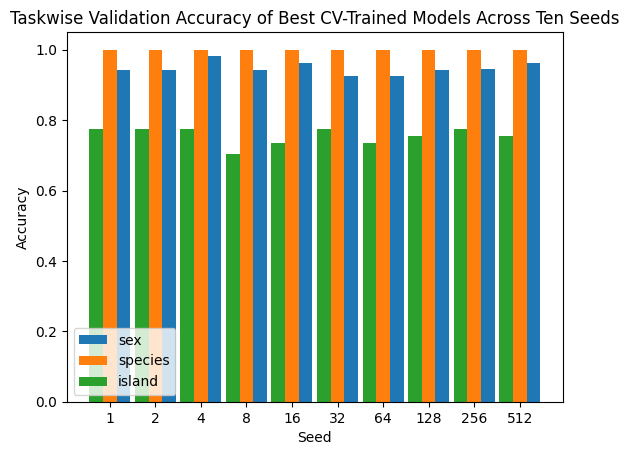

In [84]:
#fig = plt.figure(1, figsize=(7,7))
#ax1  = fig.add_subplot(211)
#ax2  = fig.add_subplot(212)
def plot_cv_val_seedwise(seed_scores):
  fig,ax = plt.subplots()
  x = seed_scores['seeds']
  a = np.arange(len(x))
  shift = -.3
  for target in [ k for k in seed_scores.keys() if k != 'seeds']:
    y = seed_scores[target]
    ax.bar(a-shift, y,label=target,width=0.3) #we plot y as a function of a, which parametrizes x
    ax.set_xticks(a) #set the ticks to be a
    ax.xaxis.set_ticklabels(x) # change the ticks' names to x
    shift+=.3
  
  plt.legend(loc='lower left')
  plt.title("Taskwise Validation Accuracy of Best CV-Trained Models Across Ten Seeds")
  plt.xlabel('Seed')
  plt.ylabel('Accuracy')
  plt.show()
  return 
plot_cv_val_seedwise(vanilla_experiments[1])

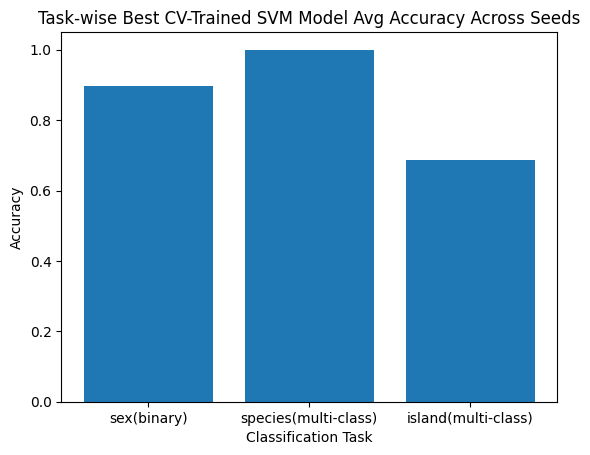

In [86]:
def plot_avg_acc(test_scores):
  tasks = list(test_scores.keys())
  tasks[0] += "(binary)"
  tasks[1] += "(multi-class)"
  tasks[2] += "(multi-class)"
  x = np.arange(len(tasks))
  scores = [test_scores[target]['avg'] for target in test_scores.keys()]
  plt.bar(tasks,scores)
  plt.title("Task-wise Best CV-Trained SVM Model Avg Accuracy Across Seeds")
  plt.ylabel("Accuracy")
  plt.xlabel("Classification Task")
  plt.show()
  return
plot_avg_acc(vanilla_experiments[4])

In [85]:
boost_experiments = (run_experiments(seeds,preprocess_data_dict,sklearn.ensemble.AdaBoostClassifier,data))

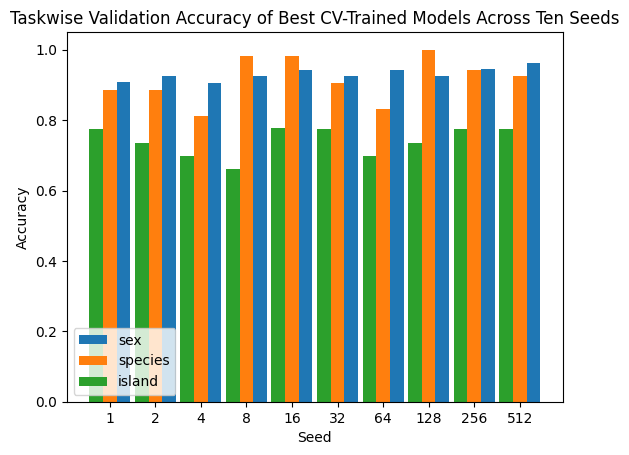

In [93]:
plot_cv_val_seedwise(boost_experiments[1])

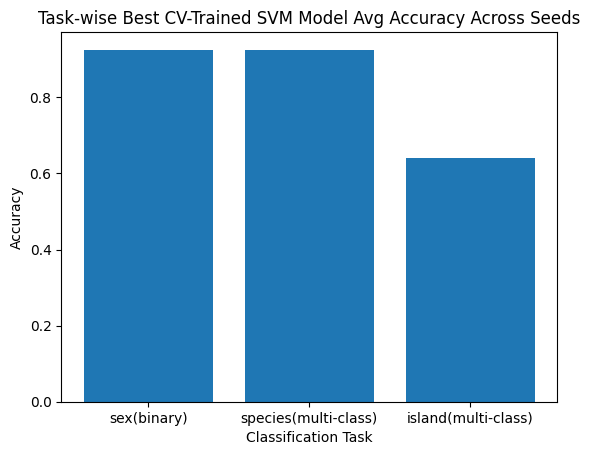

In [89]:
plot_avg_acc(boost_experiments[4])

Attempting to improve island and sex tasks with imbalance learn's SMOTE

In [29]:
from imblearn.over_sampling import SMOTENC
def pp_smote(data_dict,r_state):
  for target in data_dict.keys():
    target_splits = data_dict[target]
    cat_col_mask = [True if col in ['species','sex','island'] else False for col in target_splits['train']['X'].columns]
    sm = SMOTENC(categorical_features=cat_col_mask,sampling_strategy='not majority')
    target_splits['train']['X'],target_splits['train']['Y']=sm.fit_resample(target_splits['train']['X'],target_splits['train']['Y'])
    scaler = preprocessing.StandardScaler().fit(target_splits['train']['X'])
    for label in ('train','val','test'):
      split = target_splits[label]['X']
      if split is not None:
        target_splits[label]['X'] = scaler.transform(split)
    data_dict[target] = target_splits
  return data_dict


In [94]:
smote_experiments = run_experiments(seeds,pp_smote,sklearn.svm.LinearSVC,data)

In [102]:
smote_boost_experiments = (run_experiments(seeds,pp_smote,sklearn.ensemble.Adaboostclassifier,data))

In [104]:
knn_experiments = (run_experiments(seeds,preprocess_data_dict,sklearn.neighbors.KNeighborsClassifier,data))
knn_boost_experiments = (run_experiments(seeds,pp_smote,sklearn.neighbors.KNeighborsClassifier,data))

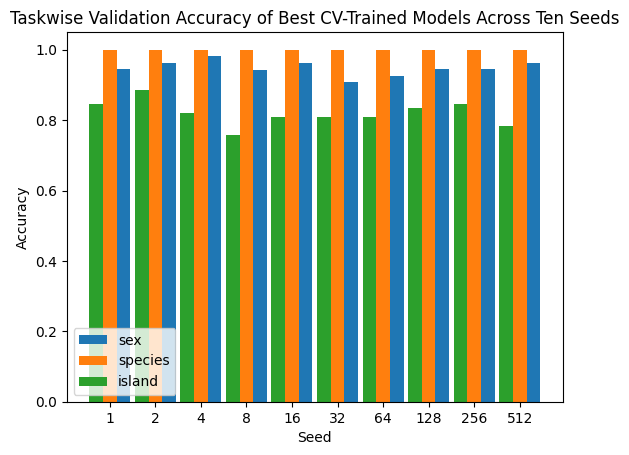

In [95]:
plot_cv_val_seedwise(smote_experiments[1])

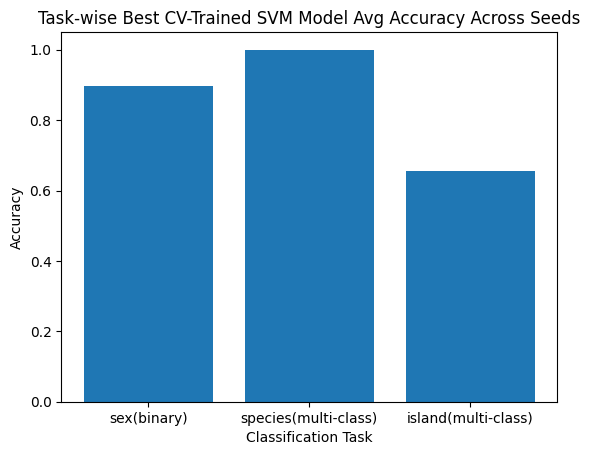

In [96]:
plot_avg_acc(smote_experiments[4])

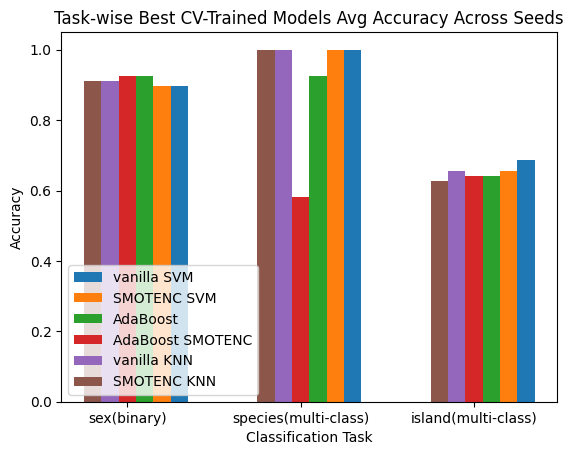

In [110]:
def compare_avg_acc(exp_dict,tasks):
  tasks[0] += "(binary)"
  tasks[1] += "(multi-class)"
  tasks[2] += "(multi-class)"
  x = np.arange(len(tasks))
  shift = -0.3
  for exp in exp_dict.keys():
    experiment = exp_dict[exp]
    scores = [experiment[target]['avg'] for target in experiment.keys()]
    plt.bar(x-shift,scores,label=exp,width=0.1)
    shift+=0.1
  plt.title("Task-wise Best CV-Trained Models Avg Accuracy Across Seeds")
  plt.ylabel("Accuracy")
  plt.xlabel("Classification Task")
  plt.xticks(x, tasks)
  plt.legend(loc='lower left')
  plt.show()
  return
exp_dict = {'vanilla SVM':vanilla_experiments[4],'SMOTENC SVM':smote_experiments[4],'AdaBoost':boost_experiments[4],'AdaBoost SMOTENC':smote_boost_experiments[4],
            'vanilla KNN':knn_experiments[4],'SMOTENC KNN':knn_boost_experiments[4]}
compare_avg_acc(exp_dict,tasks=['sex','species','island'])

In [111]:
def print_scores(exp_dict):
 for exp in exp_dict.keys():
    experiment = exp_dict[exp]
    for target in experiment.keys():
      print(f"{exp} Acc for {target}: {experiment[target]['avg']:.2f}")


In [113]:
print_scores(exp_dict)

vanilla SVM Acc for sex: 0.90
vanilla SVM Acc for species: 1.00
vanilla SVM Acc for island: 0.69
SMOTENC SVM Acc for sex: 0.90
SMOTENC SVM Acc for species: 1.00
SMOTENC SVM Acc for island: 0.66
AdaBoost Acc for sex: 0.93
AdaBoost Acc for species: 0.93
AdaBoost Acc for island: 0.64
AdaBoost SMOTENC Acc for sex: 0.93
AdaBoost SMOTENC Acc for species: 0.58
AdaBoost SMOTENC Acc for island: 0.64
vanilla KNN Acc for sex: 0.91
vanilla KNN Acc for species: 1.00
vanilla KNN Acc for island: 0.66
SMOTENC KNN Acc for sex: 0.91
SMOTENC KNN Acc for species: 1.00
SMOTENC KNN Acc for island: 0.63
